# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW01] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas
from numpy.linalg import norm

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv):
    df = pandas.read_csv(path_to_csv)
    df = df.sample(frac=1).reset_index(drop=True)
    Y = df['label'].values.tolist()
    Y = np.array([1 if i == 'M' else 0 for i in Y])
    X = np.array(df.drop('label', axis=1))
    return X,Y

def read_spam_dataset(path_to_csv):
    df = pandas.read_csv(path_to_csv)
    df = df.sample(frac=1).reset_index(drop=True)
    Y = df['label'].values.tolist()
    Y = np.array(Y)
    #Y = np.array([1 if i == 'M' else 0 for i in Y])
    X = np.array(df.drop('label', axis=1))
    return X,Y

In [3]:
read_spam_dataset("spam.csv")

(array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 1.500e+00, 3.000e+00,
         6.000e+00],
        [3.200e-01, 0.000e+00, 6.400e-01, ..., 3.613e+00, 6.300e+01,
         3.180e+02],
        [1.800e-01, 0.000e+00, 5.500e-01, ..., 1.428e+00, 5.000e+00,
         8.000e+01],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.111e+00, 1.800e+01,
         5.700e+01],
        [9.000e-02, 0.000e+00, 2.700e-01, ..., 3.758e+00, 6.900e+01,
         5.300e+02],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.967e+00, 1.800e+01,
         1.200e+02]]), array([0, 1, 0, ..., 1, 1, 0]))

In [4]:
X,y=read_cancer_dataset("cancer.csv")

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [5]:
def train_test_split(X, y, ratio):
    split = round(ratio * X.shape[0])
    X_train = X[:split]
    y_train = y[:split]
    X_test =  X[split:]
    y_test = y[split:]

    return X_train, y_train, X_test, y_test

In [6]:
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
print(y_train)
print(y_test)

[0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0
 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0
 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0
 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1
 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0
 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0
 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1
 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0
 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0
 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0
 1 1 0 0 0 0 0 1 0 1 0 0 

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [7]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = len(np.unique(list(y_pred) + list(y_true)))
    precision = np.empty(shape = classes)
    recall = np.empty(shape = classes)
    
    for i in range(classes):
        TP = sum(np.logical_and(y_pred == i, y_true == i))
        FP = sum(np.logical_and(y_pred == i, y_true != i))   
        FN = sum(np.logical_and(y_pred != i, y_true == i))   
        precision[i] = TP/(TP + FP)
        recall[i] = TP/(TP + FN)
        
    accuracy = sum(y_pred == y_true)/y_pred.size
    
    return precision, recall, accuracy
    

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [8]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [9]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [10]:
import heapq
from heapq import heappop
from heapq import heappush
from heapq import heappushpop

In [11]:
class Node:
    def __init__(self, median = None, dim = None, left = None, right = None, data = None):
        self.left = left
        self.right  = right
        self.median = median
        self.dim=dim
        self.X = X
        self.data = data

In [12]:

class KDTree:
    
    def __init__(self, X, leaf_size = 40):
        self. leaf_size =  leaf_size
        self.tree = self.build(X, 0, np.arange(X.shape[0]))   
    
    def build(self, X, coordinate, index):
            
            if X is None:
                return None
            
            while X.shape[0] > self.leaf_size:
                #ind = np.argsort(X[:,coordinate])
                median = X.shape[0]//2
                ind = np.argpartition(X[:,coordinate], median)
                #median = np.median(X[:,coordinate])
                new_X = X[ind] 
                new_coordinate = (coordinate + 1) % X.shape[1]   
                new_index = index[ind]
                return Node( new_X[median],coordinate, self.build(new_X[:median], new_coordinate,new_index[:median]),
                                    self.build(new_X[median+1:],new_coordinate,new_index[median+1:]), new_index[median])
            return Node(data=(X,index))
        
    def queryElement(self, x , k ):       
        
        neighbors = []
        def search(node):
            
            if node is None:
                return 
            
            if not node.left and not node.right:                
                for elem, i in zip(*node.data):
                    dist = -norm(elem-x)
                    if len(neighbors) < k:
                        heappush(neighbors, (dist, i))
                    elif dist > neighbors[0][0]:
                        heappushpop(neighbors, (dist, i))
           
            else:
                dist = -norm(node.median-x)
                if len(neighbors) < k:
                    heappush(neighbors, (dist, node.data))
                elif dist > neighbors[0][0]:
                    heappushpop(neighbors, (dist, node.data)) 
                dim = node.dim
                diff = x[dim] - node.median[dim]
                subtree = (node.left, node.right) if diff < 0 else (node.right, node.left)
                search(subtree[0])
                if -abs(diff) > neighbors[0][0]:
                    search(subtree[1])
        
        search(self.tree)
        neighbors_ind = [heappop(neighbors)[1] for i in range(len(neighbors))]
        return neighbors_ind[::-1]
        
        
    def query(self, X, k=1):
        all_neighbors = [self.queryElement(x , k) for x in X]
        return all_neighbors

                    

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [13]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [14]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.k = n_neighbors
        self.leaf_size = 30
    
    def fit(self, X, y):
        quantile25, quantile75 = np.quantile(X,(0.25,0.75),axis = 0)
        self.q = quantile75 - quantile25 
        self.q[self.q == 0] = 1
        self.median = np.median(X, axis = 0)
        X = (X-self.median)/self.q
        self.y = y
        self.kdTree = KDTree(X,self.leaf_size)
        self.num_classes  = len(np.unique(y))
        
        
    def predict_proba(self, X):
        k = self.k
        X = (X-self.median)/self.q
        probabilities = np.empty((X.shape[0], self.num_classes))
        neighbors = self.kdTree.query(X,k)
        for i, neighbors_for_x in enumerate(neighbors):
            for y in range(self.num_classes):
                probabilities[i][y] = sum(self.y[neighbors_for_x] == y)/k
        return probabilities
            
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

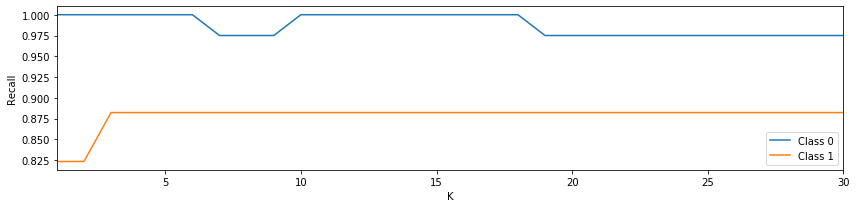

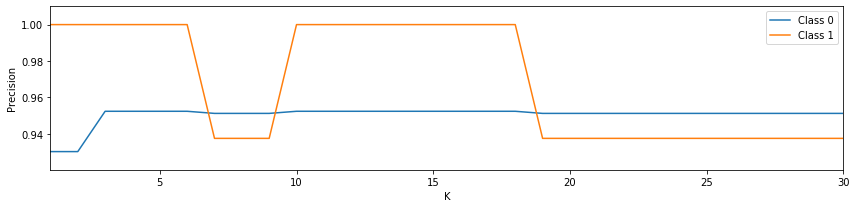

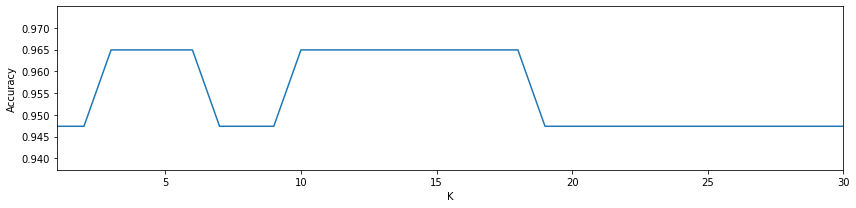

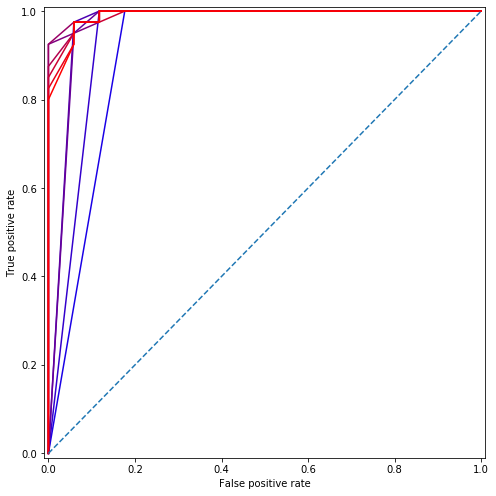

In [50]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

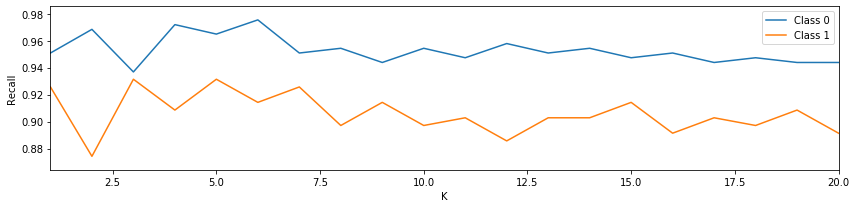

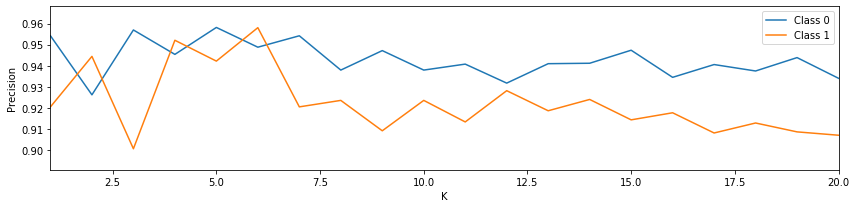

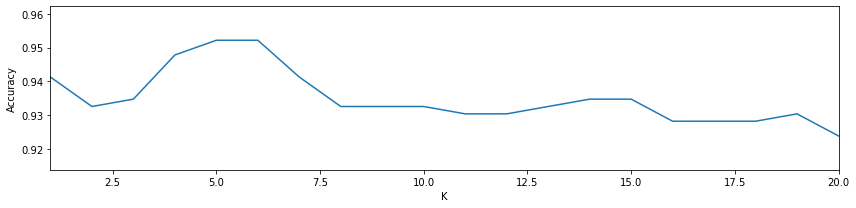

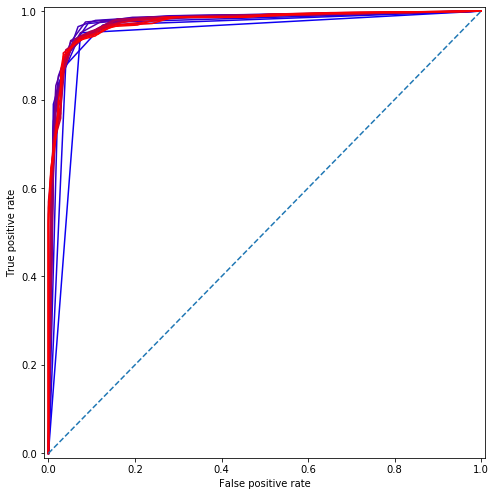

In [51]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)